In [3]:
# !pip install duckduckgo-search
# !pip install youtube-search
# !pip install youtube-transcript-api

In [16]:
from duckduckgo_search import DDGS
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

def get_image_of_dish(recipe_name):
    '''this function returns a list of image urls'''
    image_urls = []
    with DDGS() as ddgs:
        keywords = recipe_name
        ddgs_images_gen = ddgs.images(
        keywords,region="wt-wt",safesearch="off",size=None,type_image=None,layout=None,license_image=None,max_results=10)
        image_urls.extend(r['image'] for r in ddgs_images_gen)
    return image_urls

def display_image(image_url_list):
    '''this function displays the first image possible from all the urls'''
    for i in image_url_list:
        try:
            a = io.imread(i)
            plt.imshow(a)
            plt.axis('off')
            plt.show()
            break 
        except:
            None

In [30]:
results[0].keys()

dict_keys(['id', 'thumbnails', 'title', 'long_desc', 'channel', 'duration', 'views', 'publish_time', 'url_suffix'])

In [47]:
from youtube_search import YoutubeSearch
from youtube_transcript_api import YouTubeTranscriptApi

def get_eng_recipe(recipe_name, min_duration = 10):
    '''this function uses transcript api to find recipes with eng subtitles and list them,
    and returns a list of dictionaries with video details'''
    eng_recipe = []
    results = YoutubeSearch(recipe_name, max_results=100).to_dict()
    for result in results:
        # checking if the duration >10 minutes
        if float(result['duration'].split(':')[0]) >= min_duration: 
            try:
                transcript_list = YouTubeTranscriptApi.list_transcripts(result['id'])
                for transcript in transcript_list:
                    # check if the lang is english
                    if 'en' in transcript.language_code:
                        eng_recipe.append(result)
                    if len(eng_recipe) == 10:
                        break
            except:
                None
    return eng_recipe

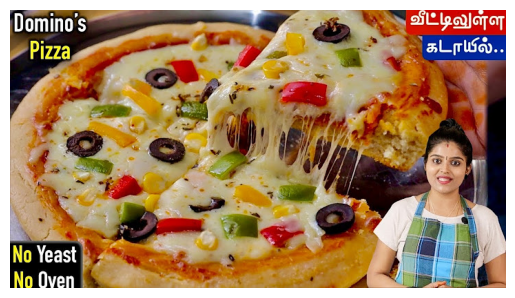

In [48]:
eng_recipe = get_eng_recipe('pizza')
thumbnail_urls = [i['thumbnails'][-1] for i in eng_recipe]
display_image(thumbnail_urls)

In [49]:
for i in eng_recipe:
    print(i)

{'id': 'cEUNUr9gfz8', 'thumbnails': ['https://i.ytimg.com/vi/cEUNUr9gfz8/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLDy6-KWHQmOu-whngbr4GESaHkkCQ', 'https://i.ytimg.com/vi/cEUNUr9gfz8/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLC-4WISY-JUd2MQzC4e0X0muOobGA'], 'title': "Make Asia Domino's Pizza at home without an oven Domino's Pizza Recipe in Tamil | pizza", 'long_desc': None, 'channel': 'Indian Recipes Tamil', 'duration': '14:35', 'views': '1,509,144 views', 'publish_time': '1 year ago', 'url_suffix': '/watch?v=cEUNUr9gfz8&pp=ygUFcGl6emE%3D'}
{'id': 'b9ehRN1_04o', 'thumbnails': ['https://i.ytimg.com/vi/b9ehRN1_04o/hq720.jpg?sqp=-oaymwEjCOgCEMoBSFryq4qpAxUIARUAAAAAGAElAADIQj0AgKJDeAE=&rs=AOn4CLAt4JtrD00AU97ZVpBdO_xgR7UJ_Q', 'https://i.ytimg.com/vi/b9ehRN1_04o/hq720.jpg?sqp=-oaymwEXCNAFEJQDSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLA79B9J7684ZypK83fixwSQf7513g'], 'title': 'Kids learn how to cook pizza and help each other', 'long_desc': None,

In [52]:
for i in eng_recipe:    
    transcript_list = YouTubeTranscriptApi.list_transcripts(i['id'])
    for transcript in transcript_list:
        # check if the lang is english
        print(
                transcript.video_id,'\n',
                transcript.language,'\n',
                transcript.language_code,'\n',
                # whether it has been manually created or generated by YouTube
                transcript.is_generated,'\n',
                # whether this transcript can be translated or not
                transcript.is_translatable,'\n',
                # a list of languages the transcript can be translated to
                transcript.translation_languages,'\n',
                )

cEUNUr9gfz8 
 English (auto-generated) 
 en 
 True 
 True 
 [{'language': 'Afrikaans', 'language_code': 'af'}, {'language': 'Akan', 'language_code': 'ak'}, {'language': 'Albanian', 'language_code': 'sq'}, {'language': 'Amharic', 'language_code': 'am'}, {'language': 'Arabic', 'language_code': 'ar'}, {'language': 'Armenian', 'language_code': 'hy'}, {'language': 'Assamese', 'language_code': 'as'}, {'language': 'Aymara', 'language_code': 'ay'}, {'language': 'Azerbaijani', 'language_code': 'az'}, {'language': 'Bangla', 'language_code': 'bn'}, {'language': 'Basque', 'language_code': 'eu'}, {'language': 'Belarusian', 'language_code': 'be'}, {'language': 'Bhojpuri', 'language_code': 'bho'}, {'language': 'Bosnian', 'language_code': 'bs'}, {'language': 'Bulgarian', 'language_code': 'bg'}, {'language': 'Burmese', 'language_code': 'my'}, {'language': 'Catalan', 'language_code': 'ca'}, {'language': 'Cebuano', 'language_code': 'ceb'}, {'language': 'Chinese (Simplified)', 'language_code': 'zh-Hans'},